<a href="https://colab.research.google.com/github/mykewe/Classify_fruits/blob/master/Fruit_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fruits Classifier


Import libraries

In [1]:
from fastai.vision import *
from fastai.widgets import *

Mount drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
root_dir = "drive/My Drive/"
base_dir = root_dir + 'DL_Projects/'

Ignore warnings

In [4]:
import warnings
warnings.filterwarnings("ignore")

Create directory and upload urls file into your server

In [7]:
path = Path(base_dir+'Classify_fruits/data/fruits')
dest = path
dest.mkdir(parents=True, exist_ok=True)

In [12]:
classes = ['apple','pear','mangoe', 'lemon','orange']
for folder in classes:
  file = 'urls_'+folder+'.csv'
  path = Path(base_dir+'Classify_fruits/data/fruits')
  dest = path/folder
  dest.mkdir(parents=True, exist_ok=True)
  download_images(path/file, dest, max_pics=500)

Then we can remove any images that can't be opened:

In [13]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

apple


pear


mangoe


lemon


orange


View data for the first time

In [14]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

Let's take a look at some of our pictures then.

In [15]:
data.classes

['apple', 'lemon', 'mangoe', 'orange', 'pear']

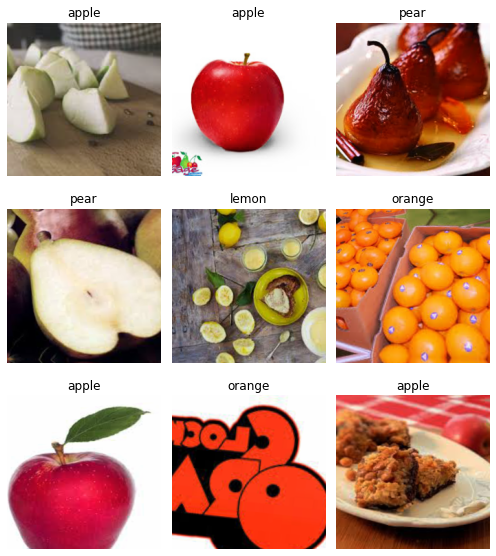

In [16]:
data.show_batch(rows=3, figsize=(7,8))

In [17]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['apple', 'lemon', 'mangoe', 'orange', 'pear'], 5, 2000, 500)

Train model

In [18]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [19]:
learn.fit_one_cycle(4)

In [20]:
learn.save('stage-1')

In [21]:
learn.unfreeze()

In [22]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


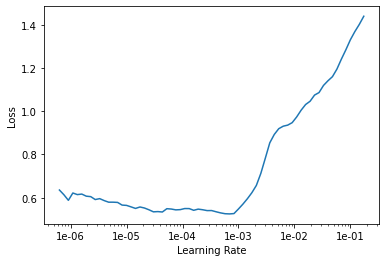

In [23]:
learn.recorder.plot()

In [24]:
learn.fit_one_cycle(2, max_lr=slice(3e-5,3e-4))

In [25]:
learn.save('stage-2')

# Interpretation

In [26]:
learn.load('stage-2');

In [27]:
interp = ClassificationInterpretation.from_learner(learn)

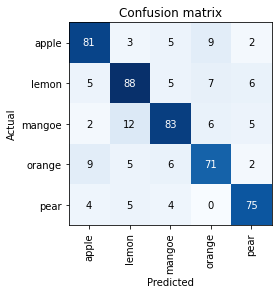

In [28]:
interp.plot_confusion_matrix()

## Cleaning Up

In order to clean the entire set of images, we need to create a new dataset without the split.

In [29]:
db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

Then we create a new learner to use our new databunch with all the images.

In [30]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)
learn_cln.load('stage-2');

Remove misclassified images

In [32]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)
ImageCleaner(ds, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

Flag photos for deletion by clicking 'Delete'. Then click 'Next Batch' to delete flagged photos and keep the rest in that row. ImageCleaner will show you a new row of images until there are no more to show

Remove duplicate images

In [34]:
ds, idxs = DatasetFormatter().from_similars(learn_cln)
ImageCleaner(ds, idxs, path, duplicates=True)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

## Final training

 Recreate the databunch and learn_cln from the cleaned.csv file

In [35]:
np.random.seed(42)
cleaned_data = ImageDataBunch.from_csv(path, folder=".", valid_pct=0.2, csv_labels='cleaned.csv',
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [36]:
cleaned_data.classes

['apple', 'lemon', 'mangoe', 'orange', 'pear']

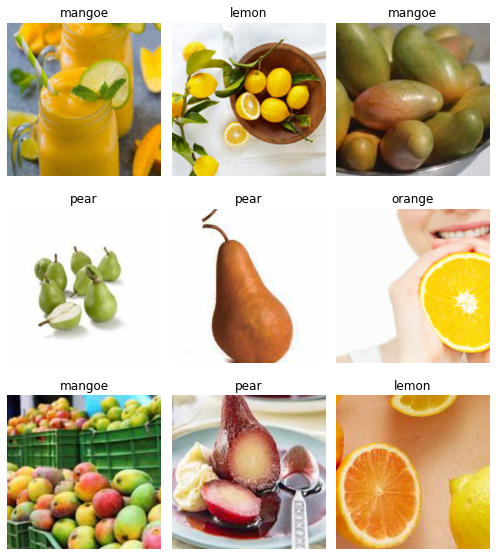

In [61]:
cleaned_data.show_batch(rows=3, figsize=(7,8))

In [38]:
print(data.classes, data.c, len(data.train_ds), len(data.valid_ds))
print(cleaned_data.classes, cleaned_data.c, len(cleaned_data.train_ds), len(cleaned_data.valid_ds))

['apple', 'lemon', 'mangoe', 'orange', 'pear'] 5 2000 500
['apple', 'lemon', 'mangoe', 'orange', 'pear'] 5 1932 482


In [44]:
learn_clnn = cnn_learner(cleaned_data, models.resnet34, metrics=error_rate)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


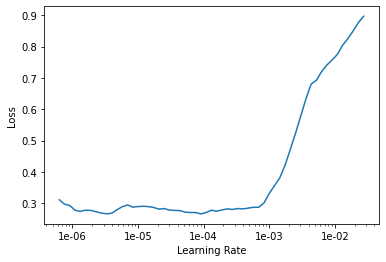

In [45]:
learn_clnn.load('stage-2') # loading the weights
learn.data = cleaned_data # replacing the data

learn_clnn.freeze()
learn_clnn.fit_one_cycle(4)

learn_clnn.unfreeze()

learn_clnn.lr_find()
learn_clnn.recorder.plot()

learn_clnn.fit_one_cycle(2, max_lr=slice(3e-5, 3e-4))
learn_clnn.save('stage-3')

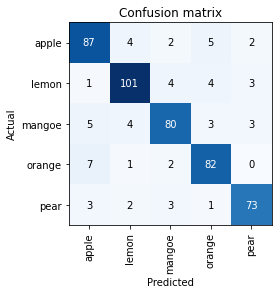

In [46]:
interp = ClassificationInterpretation.from_learner(learn_clnn)
interp.plot_confusion_matrix()

## Production

In [47]:
learn.load('stage-3');

In [48]:
learn.export()